Archive:  val.zip
   creating: val/
  inflating: __MACOSX/._val          
  inflating: val/41_AB.jpg           
  inflating: __MACOSX/val/._41_AB.jpg  
  inflating: val/100_AB.jpg          
  inflating: __MACOSX/val/._100_AB.jpg  
  inflating: val/22_AB.jpg           
  inflating: __MACOSX/val/._22_AB.jpg  
  inflating: val/163_AB.jpg          
  inflating: __MACOSX/val/._163_AB.jpg  
  inflating: val/112_AB.jpg          
  inflating: __MACOSX/val/._112_AB.jpg  
  inflating: val/53_AB.jpg           
  inflating: __MACOSX/val/._53_AB.jpg  
  inflating: val/171_AB.jpg          
  inflating: __MACOSX/val/._171_AB.jpg  
  inflating: val/30_AB.jpg           
  inflating: __MACOSX/val/._30_AB.jpg  
  inflating: val/124_AB.jpg          
  inflating: __MACOSX/val/._124_AB.jpg  
  inflating: val/65_AB.jpg           
  inflating: __MACOSX/val/._65_AB.jpg  
  inflating: val/159_AB.jpg          
  inflating: __MACOSX/val/._159_AB.jpg  
  inflating: val/18_AB.jpg           
  inflating: __MACOSX/va

In [4]:
import os

In [7]:
len(os.listdir('val'))

200

In [9]:
import os
from os import listdir
from numpy import asarray, load
from numpy import vstack
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from numpy import savez_compressed
from matplotlib import pyplot
import numpy as np
from tensorflow.keras.utils import plot_model


In [10]:
def load_images(path, size=(256,512)):
    i=0
    src_list, tar_list = list(), list()
    # enumerate filenames in directory, assume all are images
    for filename in listdir(path):
        if i==20000:
            break
        # load and resize the image
        pixels = load_img(os.path.join(path, filename), target_size=size)
        # convert to numpy array
        pixels = img_to_array(pixels)
        # split into sketch and image
        sketch_img, image_img = pixels[:, :256], pixels[:, 256:]
        src_list.append(sketch_img)
        tar_list.append(image_img)
        i+=1
    return [asarray(src_list), asarray(tar_list)]

In [11]:
path = 'val'
# load dataset
[src_images, tar_images] = load_images(path)
print('Loaded: ', src_images.shape, tar_images.shape)

Loaded:  (200, 256, 256, 3) (200, 256, 256, 3)


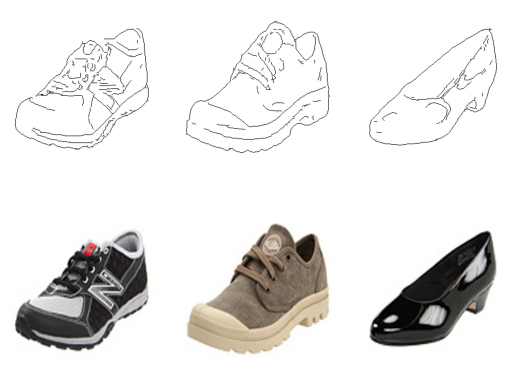

In [12]:
n_samples = 3
for i in range(n_samples):
	pyplot.subplot(2, n_samples, 1 + i)
	pyplot.axis('off')
	pyplot.imshow(src_images[i].astype('uint8'))
# plot target image
for i in range(n_samples):
	pyplot.subplot(2, n_samples, 1 + n_samples + i)
	pyplot.axis('off')
	pyplot.imshow(tar_images[i].astype('uint8'))
pyplot.show()

In [13]:
# define input shape based on the loaded dataset
image_shape = src_images.shape[1:]
image_shape

(256, 256, 3)

In [14]:
def preprocess_data(data):
	# load compressed arrays
	# unpack arrays
	X1, X2 = data[0], data[1]
	# scale from [0,255] to [-1,1]
	X1 = (X1 - 127.5) / 127.5
	X2 = (X2 - 127.5) / 127.5
	return [X1, X2]

In [15]:
data = [src_images, tar_images]

In [16]:
dataset = preprocess_data(data)

In [17]:
from numpy import zeros
from numpy import ones
from numpy.random import randint
from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import Dropout
from keras.layers import BatchNormalization
from matplotlib import pyplot as plt
from tensorflow.keras.utils import plot_model

In [19]:
def define_encoder_block(layer_in, n_filters, batchnorm=True):
	# weight initialization
    init = RandomNormal(stddev=0.02)
	# add downsampling layer
    g = Conv2D(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
	# conditionally add batch normalization
    if batchnorm:
        g = BatchNormalization()(g, training=True)
	# leaky relu activation
    g = LeakyReLU(alpha=0.2)(g)
    return g

In [20]:
def decoder_block(layer_in, skip_in, n_filters, dropout=True):
	# weight initialization
    init = RandomNormal(stddev=0.02)
	# add upsampling layer
    g = Conv2DTranspose(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
	# add batch normalization
    g = BatchNormalization()(g, training=True)
	# conditionally add dropout
    if dropout:
        g = Dropout(0.5)(g, training=True)
	# merge with skip connection
    g = Concatenate()([g, skip_in])
	# relu activation
    g = Activation('relu')(g)
    return g

In [21]:
def define_generator(image_shape=(256,256,3)):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# image input
	in_image = Input(shape=image_shape)
	# encoder model: C64-C128-C256-C512-C512-C512-C512-C512
	e1 = define_encoder_block(in_image, 64, batchnorm=False)
	e2 = define_encoder_block(e1, 128)
	e3 = define_encoder_block(e2, 256)
	e4 = define_encoder_block(e3, 512)
	e5 = define_encoder_block(e4, 512)
	e6 = define_encoder_block(e5, 512)
	e7 = define_encoder_block(e6, 512)
	# bottleneck, no batch norm and relu
	b = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(e7)
	b = Activation('relu')(b)
	# decoder model: CD512-CD512-CD512-C512-C256-C128-C64
	d1 = decoder_block(b, e7, 512)
	d2 = decoder_block(d1, e6, 512)
	d3 = decoder_block(d2, e5, 512)
	d4 = decoder_block(d3, e4, 512, dropout=False)
	d5 = decoder_block(d4, e3, 256, dropout=False)
	d6 = decoder_block(d5, e2, 128, dropout=False)
	d7 = decoder_block(d6, e1, 64, dropout=False)
	# output
	g = Conv2DTranspose(image_shape[2], (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d7) #Modified 
	out_image = Activation('tanh')(g)  #Generates images in the range -1 to 1. So change inputs also to -1 to 1
	# define model
	model = Model(in_image, out_image)
	return model

In [22]:
def define_discriminator(image_shape):
    
    # weight initialization
    init = RandomNormal(stddev=0.02) #As described in the original paper
    
	# source image input
    in_src_image = Input(shape=image_shape)  #Image we want to convert to another image
	# target image input
    in_target_image = Input(shape=image_shape)  #Image we want to generate after training. 
    
	# concatenate images, channel-wise
    merged = Concatenate()([in_src_image, in_target_image])
    
	# C64: 4x4 kernel Stride 2x2
    d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(merged)
    d = LeakyReLU(alpha=0.2)(d)
	# C128: 4x4 kernel Stride 2x2
    d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
	# C256: 4x4 kernel Stride 2x2
    d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
	# C512: 4x4 kernel Stride 2x2 
    # Not in the original paper. Comment this block if you want.
    d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
	# second last output layer : 4x4 kernel but Stride 1x1
    d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
	# patch output
    d = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
    patch_out = Activation('sigmoid')(d)
	# define model
    model = Model([in_src_image, in_target_image], patch_out)
    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=0.5)
    return model

In [23]:
def define_gan(g_model, d_model, image_shape):
	# make weights in the discriminator not trainable
	for layer in d_model.layers:
		if not isinstance(layer, BatchNormalization):
			layer.trainable = False       #Descriminator layers set to untrainable in the combined GAN but 
                                                #standalone descriminator will be trainable.
            
	# define the source image
	in_src = Input(shape=image_shape)
	# suppy the image as input to the generator 
	gen_out = g_model(in_src)
	# supply the input image and generated image as inputs to the discriminator
	dis_out = d_model([in_src, gen_out])
	# src image as input, generated image and disc. output as outputs
	model = Model(in_src, [dis_out, gen_out])
	# compile model
	opt = Adam(learning_rate=0.0002, beta_1=0.5)
    
    #Total loss is the weighted sum of adversarial loss (BCE) and L1 loss (MAE)
    #Authors suggested weighting BCE vs L1 as 1:100.
	model.compile(loss=['binary_crossentropy', 'mae'], 
               optimizer=opt, loss_weights=[1,100])
	return model

In [24]:
def generate_real_samples(dataset, n_samples, patch_shape):
	# unpack dataset
	trainA, trainB = dataset
	# choose random instances
	ix = randint(0, trainA.shape[0], n_samples)
	# retrieve selected images
	X1, X2 = trainA[ix], trainB[ix]
	# generate 'real' class labels (1)
	y = ones((n_samples, patch_shape, patch_shape, 1))
	return [X1, X2], y

In [25]:
def generate_fake_samples(g_model, samples, patch_shape):
	# generate fake instance
	X = g_model.predict(samples)
	# create 'fake' class labels (0)
	y = zeros((len(X), patch_shape, patch_shape, 1))
	return X, y

In [26]:
def summarize_performance(step, g_model, dataset, n_samples=3):
	# select a sample of input images
	[X_realA, X_realB], _ = generate_real_samples(dataset, n_samples, 1)
	# generate a batch of fake samples
	X_fakeB, _ = generate_fake_samples(g_model, X_realA, 1)
	# scale all pixels from [-1,1] to [0,1]
	X_realA = (X_realA + 1) / 2.0
	X_realB = (X_realB + 1) / 2.0
	X_fakeB = (X_fakeB + 1) / 2.0
	# plot real source images
	for i in range(n_samples):
		plt.subplot(3, n_samples, 1 + i)
		plt.axis('off')
		plt.imshow(X_realA[i])
	# plot generated target image
	for i in range(n_samples):
		plt.subplot(3, n_samples, 1 + n_samples + i)
		plt.axis('off')
		plt.imshow(X_fakeB[i])
	# plot real target image
	for i in range(n_samples):
		plt.subplot(3, n_samples, 1 + n_samples*2 + i)
		plt.axis('off')
		plt.imshow(X_realB[i])
	# save plot to file
	filename1 = 'plot_%06d.png' % (step+1)
	plt.savefig(filename1)
	plt.close()
	# save the generator model
	filename2 = 'model_%06d.h5' % (step+1)
	g_model.save(filename2)
	print('>Saved: %s and %s' % (filename1, filename2))

In [27]:
def train(d_model, g_model, gan_model, dataset, n_epochs=100, n_batch=1):
	# determine the output square shape of the discriminator
	n_patch = d_model.output_shape[1]
	# unpack dataset
	trainA, trainB = dataset
	# calculate the number of batches per training epoch
	bat_per_epo = int(len(trainA) / n_batch)
	# calculate the number of training iterations
	n_steps = bat_per_epo * n_epochs
	# manually enumerate epochs
	for i in range(n_steps):
		# select a batch of real samples
		[X_realA, X_realB], y_real = generate_real_samples(dataset, n_batch, n_patch)
		# generate a batch of fake samples
		X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)
		# update discriminator for real samples
		d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)
		# update discriminator for generated samples
		d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)
		# update the generator
		g_loss, _ = gan_model.train_on_batch(X_realA, [y_real, X_realB])
		# summarize performance
		print('>%d, d1[%.3f] d2[%.3f] g[%.3f]' % (i+1, d_loss1, d_loss2, g_loss))
		# summarize model performance
		if (i+1) % (bat_per_epo * 10) == 0:
			summarize_performance(i, g_model, dataset)

In [28]:
d_model = define_discriminator(image_shape)

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [29]:
d_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 256, 256,  │          0 │ input_layer[0][0… │
│ (Concatenate)       │ 6)                │            │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │      6,208 │ concatenate[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, 128, 128,  │          0 │ conv2d[0][0]      │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 64, 64,    │    131,200 │ leaky_re_lu[0][0] │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 64, 64,    │        512 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_1       │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 32, 32,    │    524,544 │ leaky_re_lu_1[0]… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │      1,024 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_2       │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 16, 16,    │  2,097,664 │ leaky_re_lu_2[0]… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │      2,048 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_3       │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 16, 16,    │  4,194,816 │ leaky_re_lu_3[0]… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │      2,048 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_4       │ (None, 16, 16,    │          0 │ batch_normalizat

 Total params: 6,968,257 (26.58 MB)

 Trainable params: 6,965,441 (26.57 MB)

 Non-trainable params: 2,816 (11.00 KB)

In [30]:
# Plot the model architecture and save as an image file
plot_model(d_model, to_file='discriminator_architecture.png', show_shapes=True, show_layer_names=True)


You must install pydot (`pip install pydot`) for `plot_model` to work.


In [31]:
g_model = define_generator(image_shape)

In [34]:
g_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 128, 128,  │      3,136 │ input_layer_2[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_5       │ (None, 128, 128,  │          0 │ conv2d_6[0][0]    │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 64, 64,    │    131,200 │ leaky_re_lu_5[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_7[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_6       │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 32, 32,    │    524,544 │ leaky_re_lu_6[0]… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │      1,024 │ conv2d_8[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_7       │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 16, 16,    │  2,097,664 │ leaky_re_lu_7[0]… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │      2,048 │ conv2d_9[0][0]    │
│ (BatchNormalizatio… │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_8       │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 8, 8, 512) │  4,194,816 │ leaky_re_lu_8[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 512) │      2,048 │ conv2d_10[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_9       │ (None, 8, 8, 512) │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 4, 4, 512) │  4,194,816 │ leaky_re_lu_9[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 4, 4, 512) │      2,048 │ conv2d_11[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 54,429,315 (207.63 MB)

 Trainable params: 54,419,459 (207.59 MB)

 Non-trainable params: 9,856 (38.50 KB)

In [40]:
plot_model(g_model, to_file='generator_architecture.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [55]:
gan_model = define_gan(g_model, d_model, image_shape)

In [58]:
data = [src_images, tar_images]

In [62]:
def preprocess_data(data):
	# load compressed arrays
	# unpack arrays
	X1, X2 = data[0], data[1]
	# scale from [0,255] to [-1,1]
	X1 = (X1 - 127.5) / 127.5
	X2 = (X2 - 127.5) / 127.5
	return [X1, X2]

In [64]:
dataset = preprocess_data(data)

In [86]:
from datetime import datetime 
start1 = datetime.now() 


train(d_model, g_model, gan_model, dataset, n_epochs=2, n_batch=1) 

stop1 = datetime.now()
#Execution time of the model 
execution_time = stop1-start1
print("Execution time is: ", execution_time)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
>1, d1[0.433] d2[0.433] g[0.433]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
>2, d1[0.433] d2[0.433] g[0.433]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
>3, d1[0.433] d2[0.433] g[0.433]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
>4, d1[0.433] d2[0.433] g[0.433]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
>5, d1[0.433] d2[0.433] g[0.433]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
>6, d1[0.433] d2[0.433] g[0.433]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
>7, d1[0.433] d2[0.433] g[0.433]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
>8, d1[0.433] d2[0.433] g[0.433]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
>9, d1[0.433] d2[0.433] g[0.433]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
>10, d1[0.433] d2[0.433] g[0.433]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
>11, d1[0.433] d2[0.433] g[0.433]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
>12, d1[0.433] d2[0.433] g[0.433]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
>13, d1[0.433] d2[0.433] g[0.433]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
>14, d1[0.433] d2[0.433] g[0.433]


KeyboardInterrupt: 

In [109]:
[X_realA, X_realB], _ = generate_real_samples(dataset, n_samples, 1)

In [111]:
X_fakeB, _ = generate_fake_samples(g_model, X_realA, 1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


In [113]:
import matplotlib.pyplot as plt

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


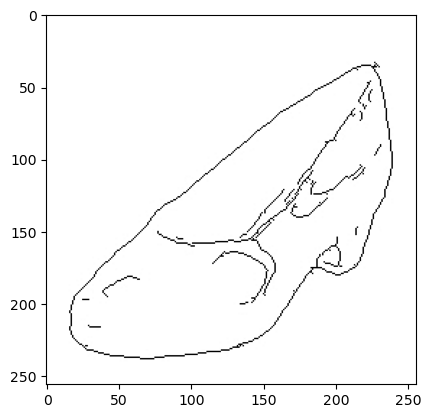

In [122]:
plt.imshow(X_realA[2])

In [128]:
import tensorflow as tf
from tensorflow import keras

In [134]:
generator = keras.models.load_model('generator_modelkaggle.h5')

In [136]:
X_fakeB, _ = generate_fake_samples(generator, X_realA, 1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step


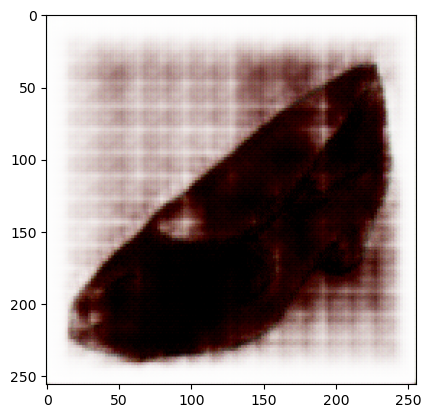

In [144]:
plt.imshow(X_fakeB[2])